### Load libraries

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import json #Files saved from google takeout were in json format
import os

In [2]:
# Load json file from my files
# Rename files so they could be better organized

folder_path = '/Users/jahdovanterpool/Downloads/Sylvia/reviews'


def rename_json_files(folder_path):
    json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('json')])
    renamed = []

    for i, old_name in enumerate(json_files):
        old_path = os.path.join(folder_path,old_name)
        new_name = f'review-{i:03}.json'
        new_path = os.path.join(folder_path,new_name)
        os.rename(old_path,new_path)
        print(f'Renamed {old_name} --> {new_name}')
        renamed.append(new_name)
    return renamed


file_name_change = rename_json_files(folder_path)
print(file_name_change)

Renamed review-000.json --> review-000.json
Renamed review-001.json --> review-001.json
Renamed review-002.json --> review-002.json
Renamed review-003.json --> review-003.json
Renamed review-004.json --> review-004.json
Renamed review-005.json --> review-005.json
Renamed review-006.json --> review-006.json
Renamed review-007.json --> review-007.json
Renamed review-008.json --> review-008.json
Renamed review-009.json --> review-009.json
Renamed review-010.json --> review-010.json
Renamed review-011.json --> review-011.json
Renamed review-012.json --> review-012.json
Renamed review-013.json --> review-013.json
Renamed review-014.json --> review-014.json
['review-000.json', 'review-001.json', 'review-002.json', 'review-003.json', 'review-004.json', 'review-005.json', 'review-006.json', 'review-007.json', 'review-008.json', 'review-009.json', 'review-010.json', 'review-011.json', 'review-012.json', 'review-013.json', 'review-014.json']


In [3]:
# Combine the json files and create one dataframe

def merge_json_in_folder(folder_path):
    merged_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            try:
                data = pd.read_json(file_path)
                merged_data = pd.concat([merged_data, data], ignore_index=True)
            except Exception as e:
                print(f"Could not read {filename}: {e}")
    merged_data.to_json('merged.json', orient='records', lines=True)
    return merged_data


merged_df = merge_json_in_folder(folder_path)
merged_df.head()

,reviews
0,{'reviewer': {'displayName': 'Angela Pressley'...
1,{'reviewer': {'displayName': 'Tywan Robinson'}...
2,"{'reviewer': {'displayName': 'roy burgess'}, '..."
3,"{'reviewer': {'displayName': 'DDA'}, 'starRati..."
4,"{'reviewer': {'displayName': 'Willie Eady'}, '..."


In [4]:
# Convert Json semi structured data puts it into a proper dataframe
# Fill missing values replies and comments with 'No reply' or just there star rating

flat_df = pd.json_normalize(merged_df['reviews'])

flat_df.rename(columns={
    'starRating':'Rating',
    'comment': 'Comment',
    'createTime': 'Date posted',
    'updateTime': 'Updated',
    'name': 'ReviewID',
    'reviewer.displayName':'Reviewer',
    'reviewReply.comment': 'Reply',
    'reviewReply.updateTime': 'ReplyUpdate'
},inplace=True)


flat_df['Reply'] = flat_df['Reply'].fillna('No Reply')
flat_df.loc[:,'Comment'] = flat_df.apply(
    lambda row: f"{row['Rating']} star" if pd.isna(row['Comment']) else row['Comment'],
    axis = 1
)

flat_df.head(100)

,Rating,Comment,Date posted,Updated,ReviewID,Reviewer,Reply,ReplyUpdate
0,TWO,Customer service was very nice. The prices wer...,2022-01-18T16:52:22.018400Z,2022-01-18T16:52:22.018400Z,accounts/113125786415732178818/locations/11630...,Angela Pressley,No Reply,NaN
1,FIVE,FIVE star,2022-01-06T18:13:54.656825Z,2022-01-06T18:13:54.656825Z,accounts/113125786415732178818/locations/11630...,Tywan Robinson,No Reply,NaN
2,FOUR,FOUR star,2019-09-10T21:10:15.208764Z,2022-01-06T17:03:22.134433Z,accounts/113125786415732178818/locations/11630...,roy burgess,No Reply,NaN
3,FIVE,"Oxtails, wow, best around 3 neighboring counti...",2022-01-05T18:22:16.895742Z,2022-01-05T18:22:16.895742Z,accounts/113125786415732178818/locations/11630...,DDA,No Reply,NaN
4,FIVE,FIVE star,2021-12-10T19:37:43.238743Z,2021-12-10T19:37:43.238743Z,accounts/113125786415732178818/locations/11630...,Willie Eady,No Reply,NaN
...,...,...,...,...,...,...,...,...
95,FIVE,Best Jamaican food in Poughkeepsie I’ve been g...,2022-03-06T15:05:54.053857Z,2022-03-06T15:05:54.053857Z,accounts/113125786415732178818/locations/11630...,Roberto Ortiz,Thank you,2023-11-18T00:16:52.471179Z
96,FIVE,FIVE star,2022-02-25T07:28:45.738440Z,2022-02-25T07:28:45.738440Z,accounts/113125786415732178818/locations/11630...,Norman Smith,Thank you,2023-11-18T00:17:00.620590Z
97,FIVE,Always an enjoyable experience but be prepared...,2022-02-08T18:13:29.797840Z,2022-02-08T18:13:29.797840Z,accounts/113125786415732178818/locations/11630...,Meaghan Battle,Thank you,2023-11-18T00:17:14.042470Z
98,FIVE,FIVE star,2021-08-31T22:46:17.008788Z,2022-02-08T11:36:50.719964Z,accounts/113125786415732178818/locations/11630...,Legacy Mission,No Reply,NaN


In [5]:
# Check for null values

flat_df.isnull().sum()

Rating           0
Comment          0
Date posted      0
Updated          0
ReviewID         0
Reviewer         0
Reply            0
ReplyUpdate    229
dtype: int64

In [6]:
# Create table that just has the comments which received replies

replied_df = flat_df[flat_df['Reply'] != 'No Reply']
replied_df.head()

,Rating,Comment,Date posted,Updated,ReviewID,Reviewer,Reply,ReplyUpdate
80,FIVE,"Popped In, with my brother, Jerome. Visiting P...",2022-08-09T23:12:21.137862Z,2022-08-09T23:14:01.290592Z,accounts/113125786415732178818/locations/11630...,Charles Rhodd,Thank you so much for returning and showing us...,2022-08-28T14:52:13.194467Z
81,FIVE,Excellent food and excellent service. Very pol...,2022-07-27T06:38:25.947549Z,2022-07-27T06:38:25.947549Z,accounts/113125786415732178818/locations/11630...,stephen gould,Thank you so much,2022-09-03T02:06:11.953185Z
82,FIVE,A place you must go to eat.,2018-06-02T10:21:07.801Z,2022-07-01T20:11:31.829372Z,accounts/113125786415732178818/locations/11630...,rosem fearon,Thank you so much,2022-09-03T02:06:20.125970Z
83,FOUR,FOUR star,2022-06-24T23:24:05.566380Z,2022-06-24T23:24:05.566380Z,accounts/113125786415732178818/locations/11630...,Alizabeth Holland,Thank you,2022-09-03T02:06:31.037348Z
84,FIVE,The food was great!,2022-06-14T12:52:24.799537Z,2022-06-14T12:52:24.799537Z,accounts/113125786415732178818/locations/11630...,odetta bailey,Thank you,2023-09-21T23:27:00.887095Z


In [7]:
# Save data

flat_df.to_csv('/Users/jahdovanterpool/Downloads/Sylvia/local_sentiment_project.csv')


### Loading data & text preprocessing

In [8]:
# Load data and drop some columns

df = pd.read_csv('/Users/jahdovanterpool/Downloads/Sylvia/local_sentiment_project.csv',index_col=0)
df.drop(['ReplyUpdate','ReviewID','Updated','Reviewer','Reply'],axis=1, inplace=True)

df.head()

,Rating,Comment,Date posted
0,TWO,Customer service was very nice. The prices wer...,2022-01-18T16:52:22.018400Z
1,FIVE,FIVE star,2022-01-06T18:13:54.656825Z
2,FOUR,FOUR star,2019-09-10T21:10:15.208764Z
3,FIVE,"Oxtails, wow, best around 3 neighboring counti...",2022-01-05T18:22:16.895742Z
4,FIVE,FIVE star,2021-12-10T19:37:43.238743Z


In [9]:
# Convert ratings to integers

rating_map = {
    'TWO':2,
    'FIVE':5,
    'FOUR':4,
    'THREE':3,
    'ONE':1
              }

df['Stars'] = df['Rating'].map(rating_map)
df.drop('Rating',axis=1,inplace=True)
df.head()

,Comment,Date posted,Stars
0,Customer service was very nice. The prices wer...,2022-01-18T16:52:22.018400Z,2
1,FIVE star,2022-01-06T18:13:54.656825Z,5
2,FOUR star,2019-09-10T21:10:15.208764Z,4
3,"Oxtails, wow, best around 3 neighboring counti...",2022-01-05T18:22:16.895742Z,5
4,FIVE star,2021-12-10T19:37:43.238743Z,5


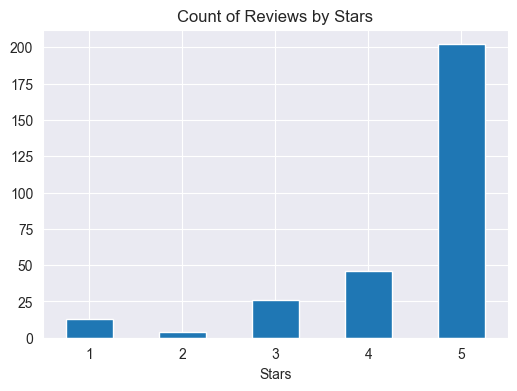

In [10]:
# Plot the count of each rating

score_counts = df['Stars'].value_counts()
ax = score_counts.sort_index(ascending=True).plot(kind='bar',
                                    title = 'Count of Reviews by Stars',
                                    figsize = (6,4),
                                    rot = 360
                                    )

plt.grid(True)
plt.show()

In [11]:
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words(['english','spanish']))

In [14]:
# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['Comment'].apply(clean_text)
df.head()

,Comment,Date posted,Stars,clean_text
0,Customer service was very nice. The prices wer...,2022-01-18T16:52:22.018400Z,2,customer service nice prices ok good caribbean...
1,FIVE star,2022-01-06T18:13:54.656825Z,5,five star
2,FOUR star,2019-09-10T21:10:15.208764Z,4,four star
3,"Oxtails, wow, best around 3 neighboring counti...",2022-01-05T18:22:16.895742Z,5,oxtails wow best around 3 neighboring counties...
4,FIVE star,2021-12-10T19:37:43.238743Z,5,five star


In [1]:
# Reorder the columns
df = df[['Stars','Comment', 'clean_text','Date posted']]
df.head()

NameError: name 'df' is not defined

In [15]:
df.columns

Index(['Comment', 'Date posted', 'Stars', 'clean_text'], dtype='object')